In [2]:
from collections import deque
import tqdm
import bench_utils
from shapely.geometry import shape
from algos.alg_fpd import Fpd
from algos.alg_fpd_extended import FpdExtended
import random
import numpy as np
from shapely.geometry import shape

fpd = FpdExtended()

df, unary_idxs = bench_utils.read_dataset()
unary_idxs = list(set(unary_idxs))

MEMORY_SLOTS = 4
# Export delta properties
X, y = [], []
for idx in tqdm.tqdm(unary_idxs, disable=True): # List of single idxs
    _, bin = fpd.compress(shape(df.iloc[idx]))
    chunks, _ = fpd.get_chunks(bin, include_ring_start=False)

    for c in chunks:
        prevs = []
        for coord in c:
            point = tuple(coord)
            
            if len(prevs) > MEMORY_SLOTS:
                prevs.pop()

            X_small = [prevs[i] if len(prevs) > i else (0, 0) for i in range(MEMORY_SLOTS)]
            y_small = point
            prevs.insert(0, point)
            X.append(X_small)
            y.append(y_small)

In [3]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn.neural_network import MLPRegressor
X = np.array(X)
y = np.array(y)

2023-04-11 16:26:52.779730: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(X.shape)
X = X.reshape((-1, X.shape[1] * X.shape[2]))
print(X.shape)
print(y.shape)

(76153, 4, 2)
(76153, 8)
(76153, 2)


In [5]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(X, y, random_state=50,test_size=0.3)
X_validation, X_test, y_validation, y_test = model_selection.train_test_split(X_validation, y_validation, random_state=50,test_size=0.3)

print('train data shape:',np.shape(X_train))
print('validation data shape:',np.shape(X_validation))
print('train labels shape:',np.shape(y_train))
print('validation labels shape:',np.shape(y_validation))
print('test labels shape:',np.shape(X_test))
print('test labels shape:',np.shape(y_test))

train data shape: (53307, 8)
validation data shape: (15992, 8)
train labels shape: (53307, 2)
validation labels shape: (15992, 2)
test labels shape: (6854, 8)
test labels shape: (6854, 2)


In [6]:
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)

#train_data = (train_data-mean) / std
#validation_data = (validation_data-mean) / std

#print(train_data)
print(mean, std)

[11.220296   47.35894595  9.22730539 38.94693727  7.49699181 31.64365885
  5.92043246 24.98931581] [ 4.71000681 19.88002721  6.05255198 25.54676011  6.53725386 27.59270309
  6.56371719 27.70449383]


In [7]:
X_train[0]

array([13.2272396, 55.7012367, 13.2272328, 55.701255 , 13.2271691,
       55.7012474, 13.2271853, 55.7012039])

In [8]:
y_train[0]

array([13.2273778, 55.7012531])

In [9]:
X_validation[0]

array([13.1713012, 55.7071852, 13.1712556, 55.7072215, 13.1714138,
       55.7072774, 13.1713468, 55.7073167])

In [10]:
import gc
gc.collect() # used to clear gpu memory 

0

In [11]:
neural_net = MLPRegressor(max_iter=2000).fit(X_train, y_train)
## Result
y_hat = neural_net.predict(X_validation)

PRINT_VALIDATION = False

pred_better_cnt = 0
for i in range(len(y_hat)):
    prev = X_validation[i][0:2]
    predicted_is_better =  np.linalg.norm(y[i] - y_hat[i]) < np.linalg.norm(y[i] - prev)
    pred_better_cnt = pred_better_cnt + 1 if predicted_is_better else pred_better_cnt
    if PRINT_VALIDATION:
        print(prev)
        print(f'{i + 1}: Diff: {y[i] - y_hat[i]}   predicted {y_hat[i]}     distance {np.linalg.norm(y[i] - y_hat[i])}')
        print(f'{i + 1}: Real: {y[i] - prev}       was       {y[i]})        distance {np.linalg.norm(y[i] - prev)}')
        print('Better:', 'YES' if predicted_is_better else 'NO')

print("Model was better in:", pred_better_cnt, '/', len(y_hat), '   (', f'{(pred_better_cnt/len(y_hat) * 100):f}%' , ')')

Model was better in: 6117 / 15992    ( 38.250375% )


In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=[None, X_train.shape[-1]], batch_size=2, dtype=tf.float32, ragged=True))
model.add(tf.keras.layers.LSTM(units=32))
model.add(tf.keras.layers.Dense(units=1))
model.compile(loss="mean_squared_error", optimizer="adam", metrics="mse")

2023-04-11 16:27:24.664578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-11 16:27:24.665517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-11 16:27:24.666896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [13]:
history_final = model.fit(x=X_train, y=y_train, epochs=10)

Epoch 1/10


ValueError: in user code:

    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 8)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 8), dtype=float32)
      • training=True
      • mask=None


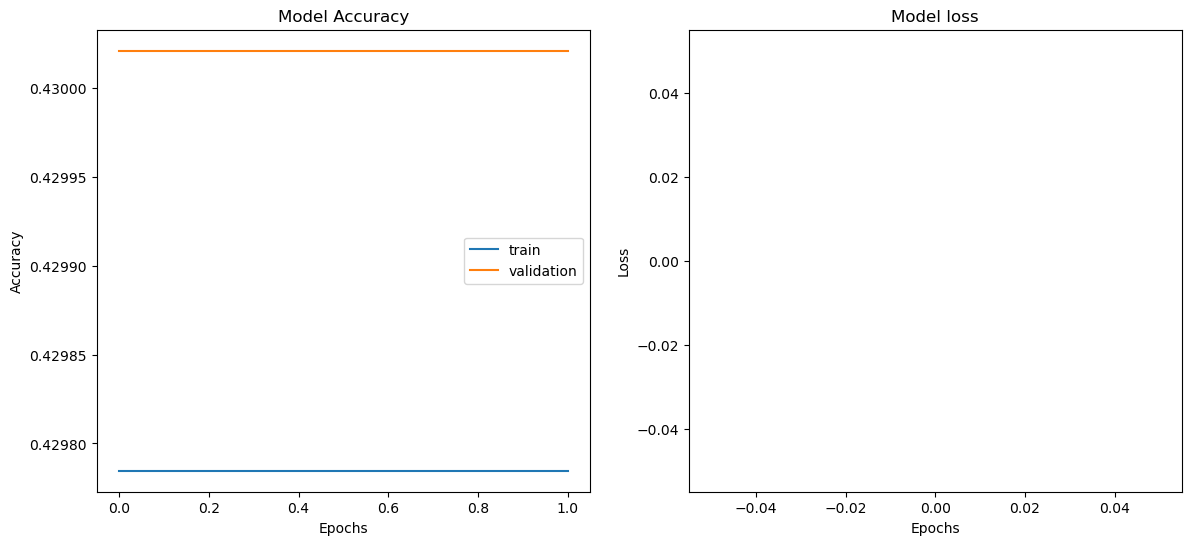

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history_final.history['accuracy'], label='train')
plt.plot(history_final.history['val_accuracy'], label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(history_final.history['loss'], label="train")
plt.plot(history_final.history['val_loss'], label="validation")

In [ ]:
y_hat = model_final.predict(X_validation)

PRINT_VALIDATION = False

pred_better_cnt = 0
for i in range(len(y_hat)):
    prev = X_validation[i][0:2]
    predicted_is_better =  np.linalg.norm(y[i] - y_hat[i]) < np.linalg.norm(y[i] - prev)
    pred_better_cnt = pred_better_cnt + 1 if predicted_is_better else pred_better_cnt
    if PRINT_VALIDATION:
        print(prev)
        print(f'{i + 1}: Diff: {y[i] - y_hat[i]}   predicted {y_hat[i]}     distance {np.linalg.norm(y[i] - y_hat[i])}')
        print(f'{i + 1}: Real: {y[i] - prev}       was       {y[i]})        distance {np.linalg.norm(y[i] - prev)}')
        print('Better:', 'YES' if predicted_is_better else 'NO')

print("Model was better in:", pred_better_cnt, '/', len(y_hat), '   (', f'{(pred_better_cnt/len(y_hat) * 100):f}%' , ')')

8257/8257 [==============================] - 6s 691us/step
Model was better in: 0 / 264222    ( 0.000000% )
